In [226]:
import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np
%matplotlib inline

In [227]:
X_SCALE = 3.0
V_SCALE = 50.0 * X_SCALE**2
F_SCALE = 30.0 # V_SCALE / X_SCALE
GRAD_F_SCALE = F_SCALE / X_SCALE

# Define NN architecture and losses

In [228]:
from torch.autograd import grad

class NNApproximator(nn.Module):
  def __init__(self, dim_input = 6, dim_output = 2, num_hidden = 2, dim_hidden = 1, activation=nn.Tanh()):
    super().__init__()

    self.layer_in = nn.Linear(4, dim_hidden)
    # self.layer_in = nn.Linear(dim_input, dim_hidden)
    self.layer_out = nn.Linear(dim_hidden, dim_output)
    self.k = nn.Parameter(torch.tensor(50.0, requires_grad=False))

    num_middle = num_hidden - 1
    self.middle_layers = nn.ModuleList(
        [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
    )
    self.activation = activation

  def forward(self, x):
    x_unit = x / X_SCALE
    s = torch.hstack((x_unit[:, 0:2] - x_unit[:, 2:4], x_unit[:, 4:6] - x_unit[:, 2:4]))
    out = self.activation(self.layer_in(s))
    for layer in self.middle_layers:
      out = self.activation(layer(out))
    return self.layer_out(out) * F_SCALE

  def _get_force_truth(self, x):
    k = 50.0
    g = torch.tensor([[0.0, -9.81]])
    L0 = 5.0
    x1 = x[:,:2]
    x2 = x[:,2:4]
    x3 = x[:,4:]
    dx1 = x2 - x1
    dx2 = x3 - x2
    dx1_norm = torch.sqrt(torch.sum(dx1 ** 2, dim=1))[:,None]
    dx2_norm = torch.sqrt(torch.sum(dx2 ** 2, dim=1))[:,None]
    f1 = -k * (dx1_norm - L0) * (dx1 / dx1_norm)
    f2 = k * (dx2_norm - L0) * (dx2 / dx2_norm)
    F = f2
    F += g
    F += f1
    return F

In [229]:
def compute_data_loss_force(model, x_tr, y_tr):
  return 0.5 * torch.mean((model.forward(x_tr).flatten() - y_tr.flatten()) ** 2) / (F_SCALE ** 2)

def compute_PINN_loss(model, x):
  F = model.forward(x)

  s1 = x[:, 0:2] - x[:, 2:4]
  s2 = x[:, 4:6] - x[:, 2:4]

  s1_unit = s1 / torch.norm(s1, dim=1)[:, None]
  s2_unit = s2 / torch.norm(s2, dim=1)[:, None]

  s1rot = s1_unit @ torch.from_numpy(np.array([[0, -1], [1, 0]]).T).float()
  s2rot = s2_unit @ torch.from_numpy(np.array([[0, -1], [1, 0]]).T).float()

  vecjac_s1 = grad(outputs=F, inputs=x, grad_outputs=s1_unit, retain_graph=True)[0]
  f1_ax = (torch.sum(s1_unit * vecjac_s1[:,0:2], dim=1) - model.k) #/ k
  f1_perp = torch.sum(s1rot * vecjac_s1[:,0:2], dim=1)

  vecjac_s2 = grad(outputs=F, inputs=x, grad_outputs=s2_unit, retain_graph=True)[0]
  f2_ax = (torch.sum(s2_unit * vecjac_s2[:,4:6], dim=1) - model.k) #/ k
  f2_perp = torch.sum(s2rot * vecjac_s2[:,4:6], dim=1)

  # extract the jacobian entry [0,3]
  m01 = torch.zeros_like(s1)
  m01[:, 0] = 1
  vecjac_01 = grad(outputs=F, inputs=x, grad_outputs=m01, retain_graph=True)[0][:,3] #[:, [1,3,5]]

  # extract the jacobian entry [1,2]
  m10 = m01[:, [1, 0]]
  vecjac_10 = grad(outputs=F, inputs=x, grad_outputs=m10)[0][:, 2]#[:, [0,2,4]]
  # conservative force constraint: F should be curl-free
  f_cons = vecjac_01 - vecjac_10

  # print(f1_ax)
  # print(f2_ax)
  # print(f1_perp)
  # print(f2_perp)
  # print(f_cons)

  loss = 0
  loss += (f1_perp ** 2).mean() + (f2_perp ** 2).mean()
  loss += (f1_ax ** 2).mean() + (f2_ax ** 2).mean()
  loss += (f_cons ** 2).mean()

  # re-scaling
  loss /= GRAD_F_SCALE ** 2

  return loss


In [230]:
# model = NNApproximator(num_hidden=6, dim_hidden=32)
# data = x.clone().requires_grad_(True)
# print(compute_PINN_loss(model, data))
# print(compute_data_loss_force(model, x.clone().requires_grad_(), F))

# Load training data

In [231]:
import pandas as pd

df = pd.read_csv('k=50_L=5_N=5_M=1.csv')
positions = df[['r0_x', 'r0_y', 'r1_x', 'r1_y', 'r2_x', 'r2_y', 'r3_x', 'r3_y','r4_x','r4_y']]
forces = df[['rddot1_x','rddot1_y','rddot2_x','rddot2_y','rddot3_x','rddot3_y']]

position_stack = np.vstack((
    positions[['r0_x','r0_y','r1_x','r1_y','r2_x','r2_y']].to_numpy(),
    positions[['r1_x','r1_y','r2_x','r2_y','r3_x','r3_y']].to_numpy(),
    positions[['r2_x','r2_y','r3_x','r3_y','r4_x','r4_y']].to_numpy()
))
forces_stack = np.vstack((
    forces[['rddot1_x','rddot1_y']].to_numpy(),
    forces[['rddot2_x','rddot2_y']].to_numpy(),
    forces[['rddot3_x','rddot3_y']].to_numpy()
))

x = torch.from_numpy(position_stack.copy()).float()
F = torch.from_numpy(forces_stack.copy()).float()


In [232]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

def train_model(model, data_loss_fn, PINN_loss_fn, learning_rate=0.0001, max_epochs=1000, USE_BFGS=False, weight_decay=5e-5):
  model.train()
  tr_losses = []
  data_losses = []
  PINN_losses = []

  # reference on torch.LBFGS usage
  # https://gist.github.com/tuelwer/0b52817e9b6251d940fd8e2921ec5e20
  # USE_BFGS = False

  if USE_BFGS:
    optimizer = torch.optim.LBFGS(model.parameters())
    print("Using BFGS optimizer ... ")
    log_iter = 10
    def closure():
        optimizer.zero_grad()
        objective = data_loss_fn(model) + PINN_loss_fn(model)
        objective.backward()
        return objective
  else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    print("Using Adam optimizer ... ")
    log_iter = 1000

  # scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=3000, eta_min=1e-6)
  min_loss = 1e9

  for epoch in range(max_epochs):
    data_loss = data_loss_fn(model)
    PINN_loss = PINN_loss_fn(model)
    loss = data_loss + PINN_loss
    if USE_BFGS:
      optimizer.step(closure)
    else:
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    # scheduler.step()

    if epoch % log_iter == 0:
      print(f"Epoch: {epoch} - Loss: {float(loss):>7f} - Data: {float(data_loss):>7f} - PINN: {float(PINN_loss):>7f}")
      print(f"Loss over entire dataset: {float(compute_data_loss_force(model, x, F).detach()):>7f}") # TODO: fix preprocess_x
    tr_losses.append(loss.detach().numpy())
    data_losses.append(data_loss.detach().numpy())
    PINN_losses.append(PINN_loss.detach().numpy())

    if epoch > 2000 and loss.item() < 0.99 * min_loss:
    #   torch.save(model.state_dict(), 'checkpoint.pth')
      min_loss = loss.item()

  plt.semilogy(tr_losses, label="Total")
  plt.semilogy(data_losses, label="Data")
  plt.semilogy(PINN_losses, label="PINN")
  plt.legend()

  print("Min loss: ", min_loss)

  return model, np.array(tr_losses)

In [233]:
# from scipy.stats import qmc

# def get_LHS_sample(input_data, N):
#   sampler = qmc.LatinHypercube(d=6)
#   sample = sampler.random(n=N)

#   data_xs = input_data #[:, indices]
#   data_xbar = torch.mean(data_xs, dim=0)
#   sample = qmc.scale(sample, (torch.min(data_xs - data_xbar - 1, dim=0)[0]).numpy(), (torch.max(data_xs - data_xbar + 1, dim=0)[0]).numpy()) + data_xbar.numpy()
#   # plt.scatter(sample[:,0],sample[:,2], s=np.ones(sample.shape[0]))

#   return sample

# Prepare training and collocation data

In [234]:
class OracleModel(NNApproximator):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return super()._get_force_truth(x)

mdl_o = OracleModel()

In [235]:
x_tr = torch.vstack((
    x[:500,:].clone(),
    x[2000:2500,:].clone(),
    x[4000:4500,:].clone()
))
y_tr = torch.vstack((
    F[:500,:].clone(),
    F[2000:2500,:].clone(),
    F[4000:4500,:].clone()
))

print(compute_data_loss_force(mdl_o, x_tr, y_tr))

x_tr += torch.randn_like(x_tr) * (torch.std(x_tr,dim=0) * 0.003)

print(compute_data_loss_force(mdl_o, x_tr, y_tr))

# sample_qmc = get_LHS_sample(x.detach(), 1024)
samples = x.detach().numpy() #np.vstack((sample_qmc, x_tr[:, :].detach()))
samples = torch.tensor(samples)
x_collocation = samples.float().requires_grad_(True)

print(compute_PINN_loss(mdl_o, x_collocation))

tensor(1.3061e-13)
tensor(0.0006)
tensor(1.2123e-12, grad_fn=<DivBackward0>)


In [236]:
x_collocation.shape
# x_tr.shape

torch.Size([6000, 6])

# Train NN

Using Adam optimizer ... 
Epoch: 0 - Loss: 119.714165 - Data: 69.751656 - PINN: 49.962509
Loss over entire dataset: 0.076225
Epoch: 1000 - Loss: 4.133353 - Data: 1.353027 - PINN: 2.780326
Loss over entire dataset: 0.001973
Epoch: 2000 - Loss: 2.572275 - Data: 0.885204 - PINN: 1.687071
Loss over entire dataset: 0.001267
Epoch: 3000 - Loss: 2.311331 - Data: 0.826713 - PINN: 1.484618
Loss over entire dataset: 0.001036
Epoch: 4000 - Loss: 2.144125 - Data: 0.750984 - PINN: 1.393141
Loss over entire dataset: 0.000892
Epoch: 5000 - Loss: 2.069387 - Data: 0.696344 - PINN: 1.373044
Loss over entire dataset: 0.000823
Min loss:  2.0533556938171387


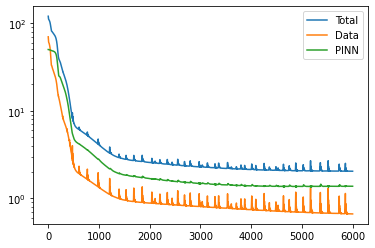

In [237]:
num_layer = 5
hidden_dim = 32
epoch = 6000
lr = 5e-4
model = NNApproximator(num_hidden=num_layer, dim_hidden=hidden_dim)

model, tr_losses = train_model(
    model,
    data_loss_fn=lambda model: 1e3*compute_data_loss_force(model, x_tr, y_tr),
    PINN_loss_fn=lambda model: 1e0*compute_PINN_loss(model, x_collocation),
    learning_rate=lr,
    max_epochs=epoch,
    weight_decay=1e-3,
)
# model.load_state_dict(torch.load('checkpoint3.pth'))

In [246]:
# from google.colab import files

# torch.save(model.state_dict(), 'checkpoint3.pth')

# # download checkpoint file
# files.download('checkpoint3.pth')

In [247]:
model.eval()
compute_PINN_loss(model, x_collocation)

tensor(1.3792, grad_fn=<DivBackward0>)

# Compute NN roll-out trajectories

In [248]:
def getqdot(x, xdot, model, xLeft, xRight):
    N_m = x.shape[0] // 2

    x = np.concatenate((xLeft, x, xRight))
    forces = []
    for i in range(0, N_m):
        triplet = x[np.arange(2*i, 2*i + 6)]
        triplet = triplet[None,:]
        force = model.forward(torch.tensor(triplet).float())
        forces.append(force.detach().numpy())

    forces = np.concatenate(forces).reshape(-1)

    q0 = np.concatenate((x, xdot))
    qdot = np.concatenate((xdot, forces))
    return qdot

def compute_trajectory(x0, x0dot, model, xLeft, xRight):
    N_m = x0.shape[0] // 2
    q0 = np.concatenate((x0, x0dot))

    t0 = 0
    tf = 20
    Nt = 2001
    sol = solve_ivp(lambda t, q: getqdot(q[:2*N_m], q[2*N_m:], model, xLeft, xRight), [t0,tf], y0=q0, t_eval=np.linspace(t0, tf, Nt))
    y = sol.y
    t = sol.t
    return y, t

In [249]:
# compute NN-predicted closed-loop trajectories
# modify as appropriate:
N_m = 5
xLeft  = (positions.iloc[0,:][['r0_x','r0_y']]).to_numpy()
xRight = (positions.iloc[0,:][['r4_x','r4_y']]).to_numpy()
mass_cols = ['r1_x','r1_y','r2_x','r2_y','r3_x','r3_y']

# # the vector 'x0' contains the initial positions of the *movable* masses
# # i.e. x0.shape = [N_m * 2]
x0 = (positions.iloc[0,:][mass_cols]).to_numpy()
x0dot = np.zeros_like(x0)

y, t = compute_trajectory(x0, x0dot, model, xLeft, xRight)

# NN roll-out trajectories

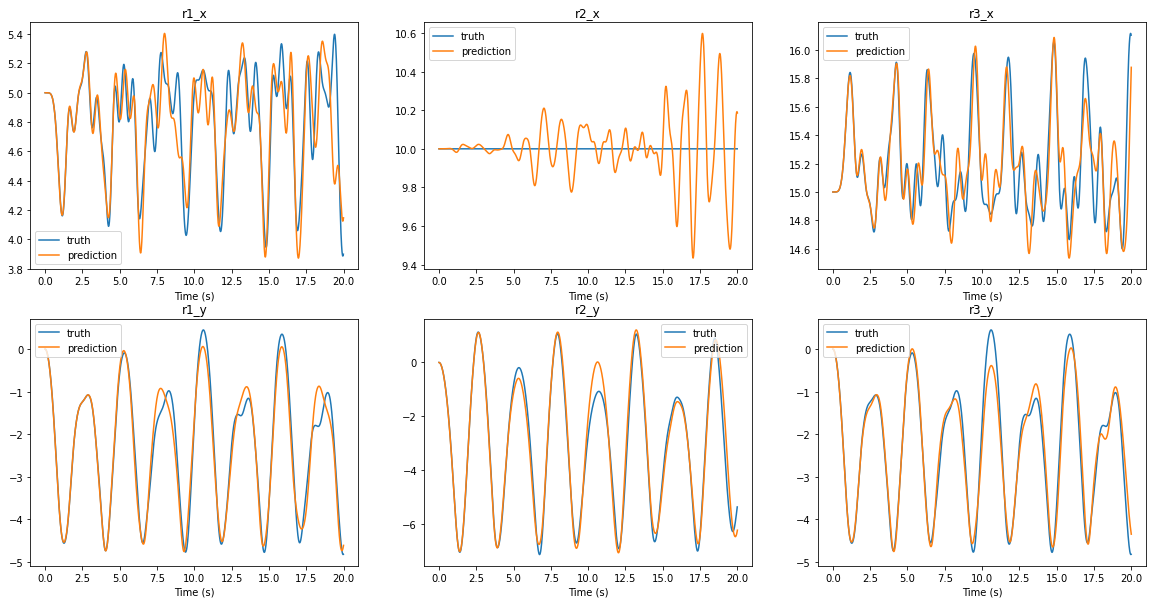

In [242]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
for i in range(6):
  m = i % 2
  n = i // 2
  curr_ax = ax[m,n]
  curr_ax.plot(df['t'], positions[mass_cols[i]].to_numpy(), label='truth')
  curr_ax.plot(t, y.T[:,i], label='prediction')
  # curr_ax.set_ylim([-10,10])
  curr_ax.set_title(mass_cols[i])
  curr_ax.set_xlabel('Time (s)')
  curr_ax.legend()

# NN predicted forces

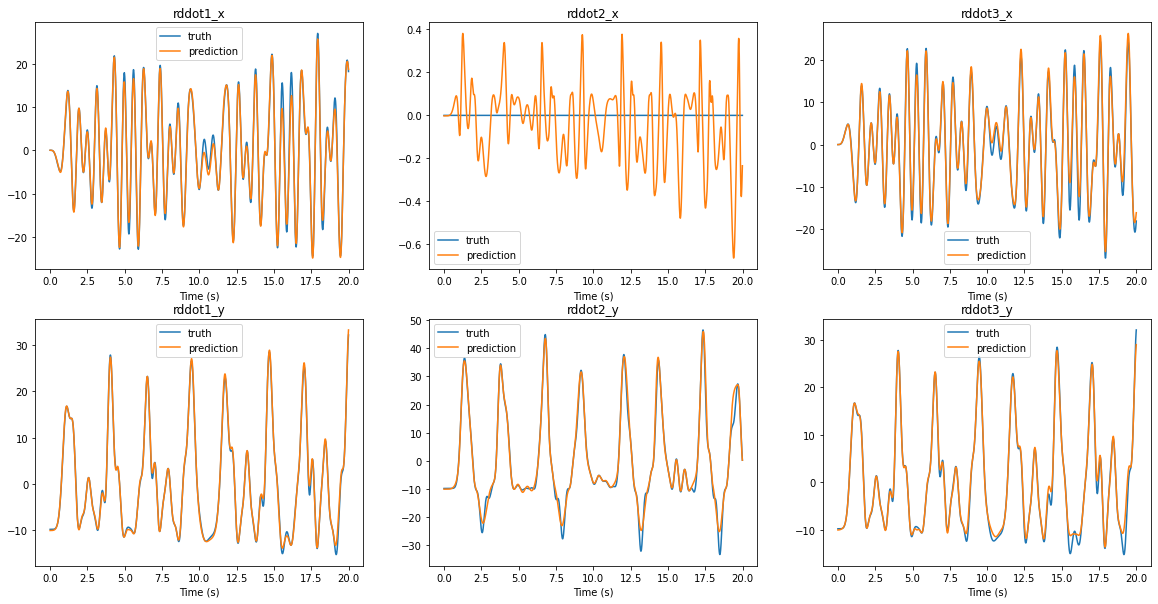

In [243]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
force_cols = ['rddot1_x', 'rddot1_y', 'rddot2_x', 'rddot2_y', 'rddot3_x', 'rddot3_y']

f_pred = model.forward(x.requires_grad_()).detach().numpy() #[:, i].detach().numpy()
Nt = df['t'].size
f_pred = np.hstack((
    f_pred[:Nt],
    f_pred[Nt:2*Nt],
    f_pred[2*Nt:]
))

for i in range(6):
  m = i % 2
  n = i // 2
  curr_ax = ax[m,n]
  curr_ax.plot(df['t'], forces[force_cols[i]].to_numpy(), label='truth')
  curr_ax.plot(df['t'], f_pred[:, i], label='prediction')
  # curr_ax.set_ylim([-10,10])
  curr_ax.set_title(force_cols[i])
  curr_ax.set_xlabel('Time (s)')
  curr_ax.legend()

In [244]:
triplet0 = np.hstack((np.vstack([xLeft] * t.size), y.T[:,:4]))
triplet1 = y.T[:,:6]
triplet2 = np.hstack((y.T[:,2:6], np.vstack([xRight] * t.size)))

tensor([-2.3858e-03, -1.0062e+01], grad_fn=<SliceBackward0>)


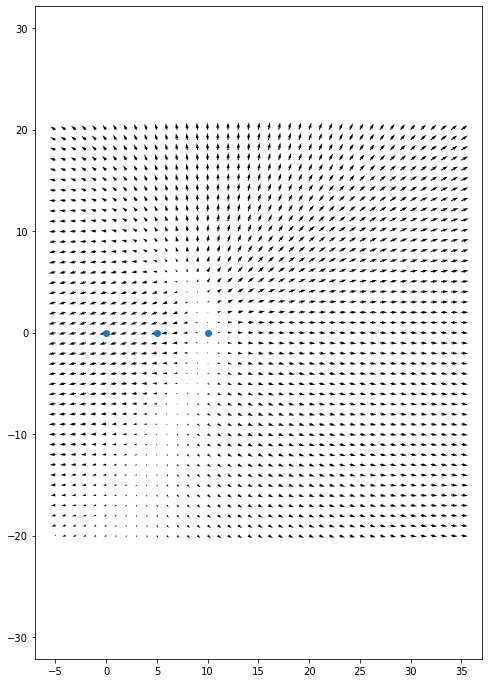

In [245]:
# "x0" is the state where the mass m3 creates zero force
x0 = torch.from_numpy(
    positions.iloc[0,:][['r0_x','r0_y','r1_x','r1_y','r2_x','r2_y']].to_numpy())
N = 41

x_c=15
y_c=0
r_max = 20
xx, yy = np.meshgrid(np.linspace(x_c-r_max, x_c+r_max, N), np.linspace(y_c-r_max, y_c+r_max, N))
plot_pts = np.c_[xx.ravel(), yy.ravel()]

x_inp = torch.zeros(size=(plot_pts.shape[0],6))
x_inp[:, :4] = x0[:4]
x_inp[:, 4:] = torch.from_numpy(plot_pts)
x_inp[0, :] = x0

Fs = model.forward(x_inp).squeeze()
F0 = Fs[0, :]

dF = (Fs - F0).detach().numpy()
# x_inp.shape

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,12))
ax.quiver(xx.ravel(), yy.ravel(), dF[:,0], dF[:,1])
ax.axis('equal')
ax.scatter(x0[0::2], x0[1::2])
print(F0)